In [1]:
# !conda install pytorch torchvision cuda90 -c pytorch -y
# !pip install qn
# !pip install numpy==1.14.5

In [2]:

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import torch
from torch.autograd import Variable,grad
from torch import nn, optim
import torch.nn.functional as F
import qn
import numpy as np

import plot
from model import DisNet, GenNet
import sampler
from progress import Progress

def cuda(tensor):
    return tensor.cuda() if torch.cuda.is_available() else tensor

def cpu(tensor):
    return tensor.cpu() if torch.cuda.is_available() else tensor


prog = Progress()
config = qn.load('hyperparams.yml')
batchsize = config['batchsize']
dis_net = cuda(DisNet(config['dim_x']))
gen_net = cuda(GenNet(config['dim_z'],config['dim_x']))

dis_optim = optim.Adam(dis_net.parameters(), lr=config['dis_lr'],
    betas=(config['dis_beta1'],config['dis_beta2']))
gen_optim = optim.Adam(gen_net.parameters(), lr=config['gen_lr'],
    betas=(config['gen_beta1'],config['gen_beta2']))


500 19.728153944015503


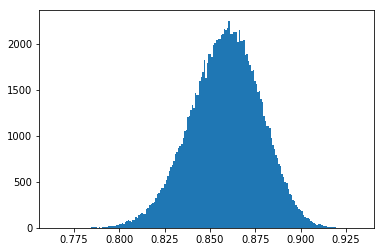

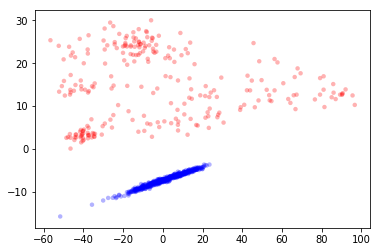

1000 19.538074016571045


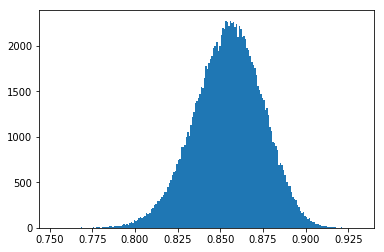

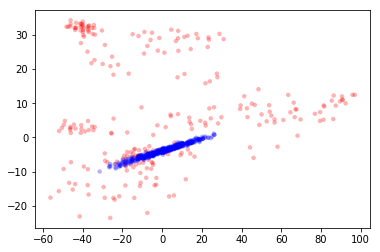

1500 19.537270545959473


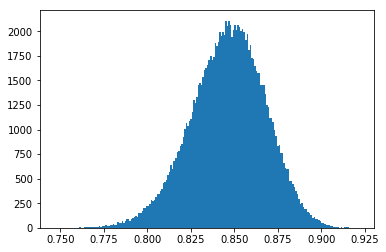

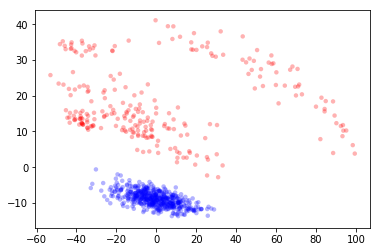

2000 19.54537343978882


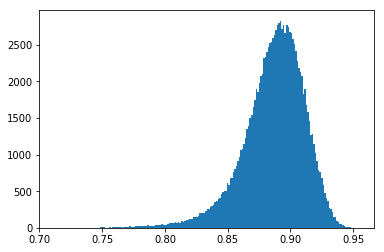

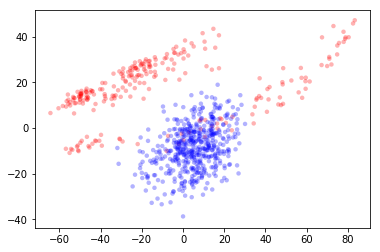

2500 19.80202889442444


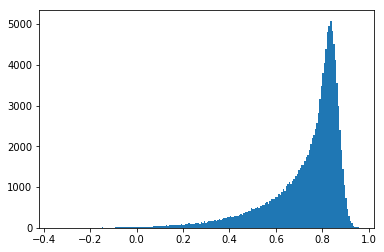

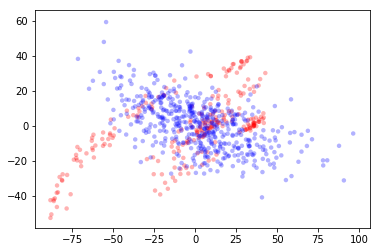

3000 19.540873289108276


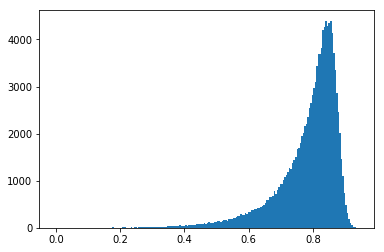

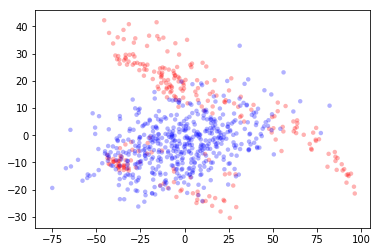

3500 19.569695234298706


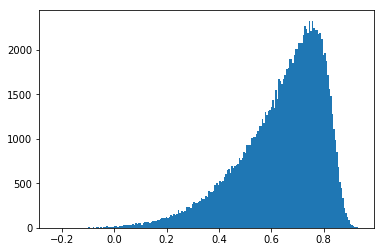

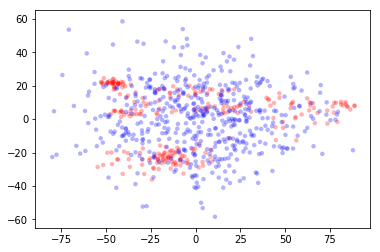

4000 19.499242067337036


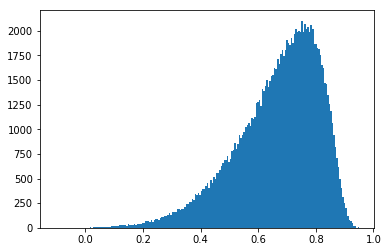

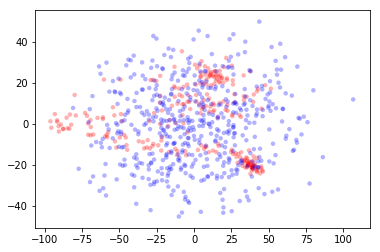

4500 19.541072845458984


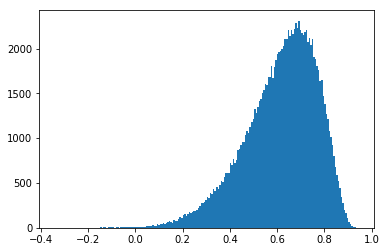

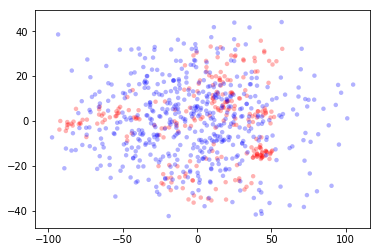

5000 19.600939989089966


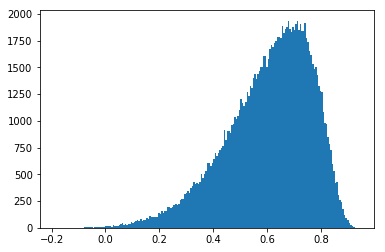

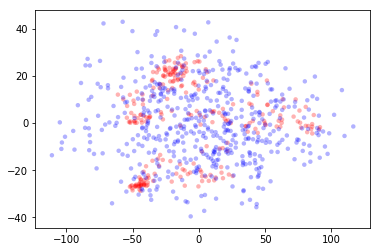

5500 19.535768747329712


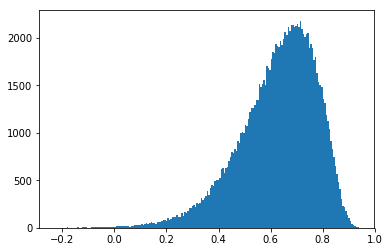

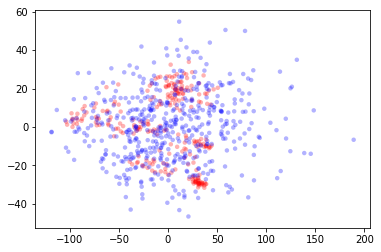

6000 19.559852838516235


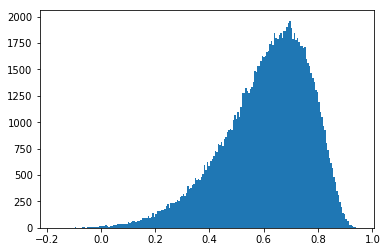

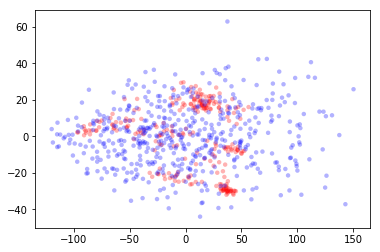

6500 19.58905529975891


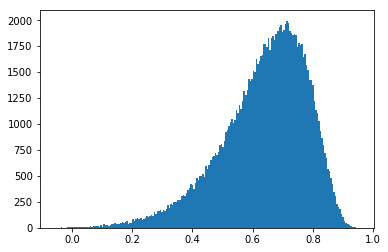

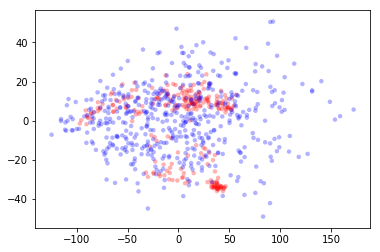

7000 19.861366033554077


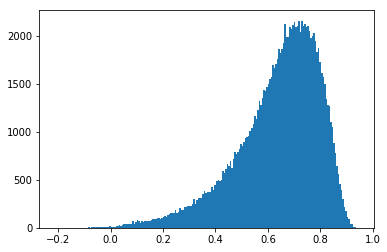

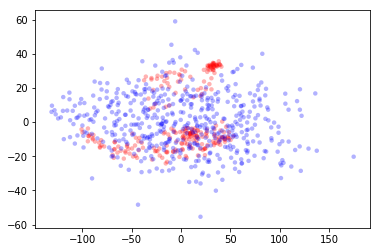

7500 19.571277141571045


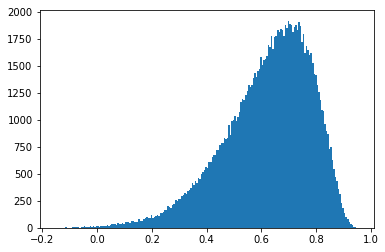

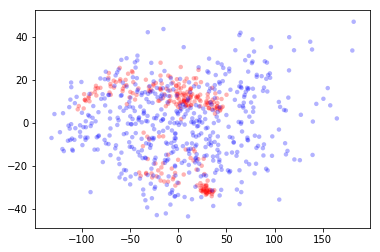

8000 19.519490242004395


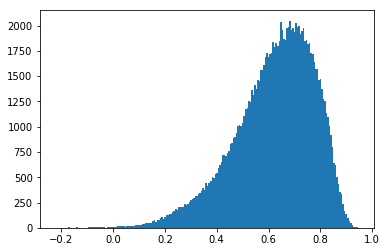

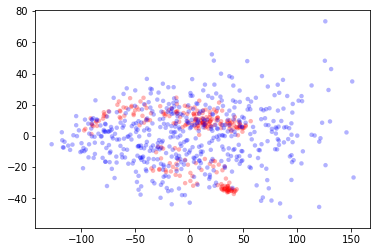

8500 19.517079830169678


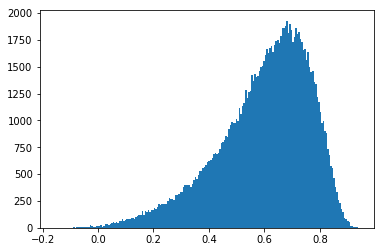

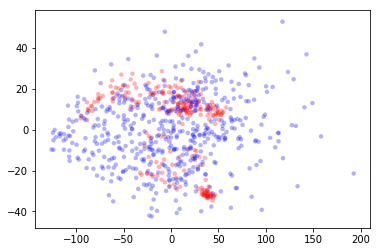

9000 19.58497977256775


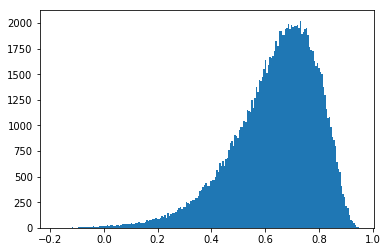

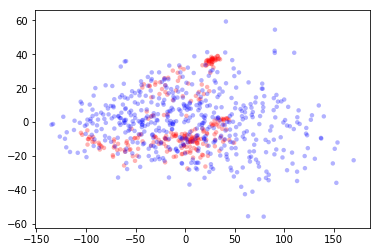

9500 19.69934844970703


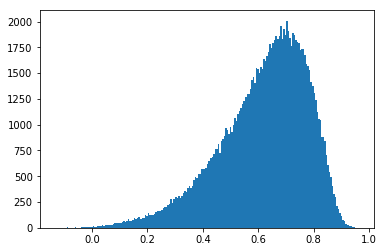

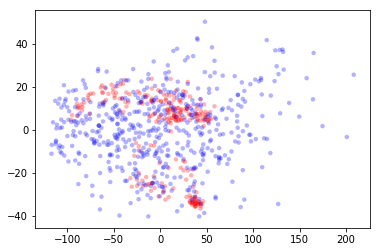

10000 19.541415214538574


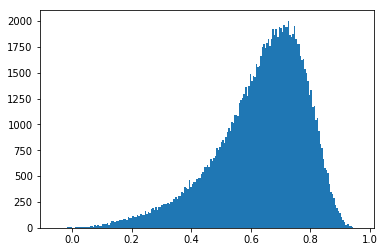

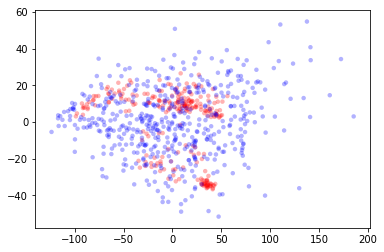

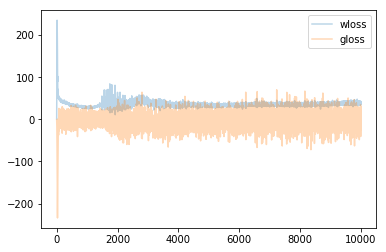

In [4]:
prog.start()
for i in range(config['num_updates']):
    for _ in range(config['num_critic']):
        gen_net.eval()
        dis_net.train()
        samples_true_numpy = sampler.sample_x(batchsize)
        samples_true = Variable(cuda(torch.from_numpy(samples_true_numpy)))
        z = sampler.sample_z(batchsize,config['dim_z'])
        z = Variable(cuda(torch.from_numpy(z)))
        samples_fake = gen_net(z).detach()
        samples_fake_numpy = cpu(samples_fake.data).numpy()      

        eps = np.random.uniform(size=batchsize).astype('float32')
        eps2 = 1 - eps
        # use transpose to broadcast
        samples_mid_numpy = (samples_true_numpy.T*eps).T + \
            (samples_fake_numpy.T*eps2).T
        samples_mid = Variable(cuda(torch.from_numpy(
            samples_mid_numpy)),requires_grad=True)
        f_mid = dis_net(samples_mid)
        # [0]:outputs tuple
        # torch.ones(): grad can be implicitly created only for scalar outputs
        grad_mid = grad(f_mid,samples_mid,cuda(torch.ones(f_mid.size())),
            create_graph=True)[0]
        grad_mid_norm = grad_mid.norm(dim=1)
        diff = (grad_mid_norm - 1).pow(2)

        f_true = dis_net(samples_true)
        f_fake = dis_net(samples_fake)
        loss_critic = f_fake.mean() - f_true.mean() + \
            (config['lda']*diff).mean()
        prog.add_loss_critic(cpu(loss_critic.data).numpy())
        
        dis_optim.zero_grad()
        loss_critic.backward()
        dis_optim.step()
    
    dis_net.eval()
    gen_net.train()
    prog.add_loss_dis()
    z = sampler.sample_z(batchsize,config['dim_z'])
    z = Variable(cuda(torch.from_numpy(z)))
    samples_fake = gen_net(z)
    f_fake = dis_net(samples_fake)
    loss_gen = -f_fake.mean()
    prog.add_loss_gen(cpu(loss_gen.data).numpy())
    
    gen_optim.zero_grad()
    loss_gen.backward()
    gen_optim.step()
    
    gen_net.eval()
    dis_net.eval()
    if (i+1)%config['num_plot'] == 0:
        print(i+1,prog.duration())
        z = sampler.sample_z(500,config['dim_z'])
        z = Variable(cuda(torch.from_numpy(z)))
        samples_fake = cpu(gen_net(z).data).numpy()
        plot.plot_corr(samples_fake, filename='{}_corr'.format(i+1),show=True)
        plot.plot_scatter(sampler.mat[:,:500].T,samples_fake[:500,:],
            filename='{}_scatter'.format(i+1),show=True)
        if (i+1) > 2000:
            torch.save(dis_net.state_dict(),'temp_models/dis_net_{}.pt'.format(i+1))
            torch.save(gen_net.state_dict(),'temp_models/gen_net_{}.pt'.format(i+1))
        prog.start()
prog.plot()


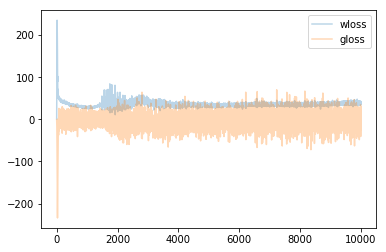

DisNet(
  (fc1): Linear(in_features=6982, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)

In [5]:
prog.plot()
dis_net

In [6]:
# torch.save(dis_net.state_dict(),'models/model_1/dis_net.pt')
# torch.save(gen_net.state_dict(),'models/model_1/gen_net.pt')
# !cp model.py models/model_1/
torch.save(cpu(dis_net).state_dict(),'temp_models/dis_net_cpu_{}.pt'.format(10000))


In [7]:
# dis_state = torch.load('models/ipf/dis_net_3700.pt')
# gen_state = torch.load('models/ipf/gen_net_3700.pt')
# dis_net.load_state_dict(dis_state)
# gen_net.load_state_dict(gen_state)

In [8]:
# torch.save(dis_net.cpu().state_dict(),'models/ipf/dis_net_3700_cpu.pt')
# torch.save(gen_net.cpu().state_dict(),'models/ipf/gen_net_3700_cpu.pt')